In [1]:
## Import

In [1]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
## Import network

In [3]:
network = 'stkl_no_control'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [4]:
wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
wn.options.hydraulic.demand_model = 'DD' #dynamic demand model
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
demand = np.maximum(demand, 0)


In [6]:
timesteps = demand.index.tolist()

In [7]:
# Calculate the total number of timesteps
num_timesteps = len(timesteps)

# Initialize the 3-dimensional array 'A' to store link information
num_links = wn.num_links
A = np.zeros((num_timesteps, num_links, 4))

# Outer loop to go through each timestep in the sequence
for timestep_idx in range(num_timesteps):
    # Inner loop to go through each link in the water network
    for i, (_, link) in enumerate(wn.links()):
        # Extract the numeric part of the node names using string manipulation
        start_node_name = link.start_node.name
        end_node_name = link.end_node.name
        A[timestep_idx, i, 0] =float( start_node_name[-4:])
        A[timestep_idx, i, 1] = float(end_node_name[-4:])
        A[timestep_idx, i, 2] = float(link.name[-4:])
        # Access loss coefficient from the DataFrame 'loss_co'
        if link.link_type=='Pipe':
            A[timestep_idx, i, 3] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[timestep_idx, i, 3] = 1        
        elif link.link_type=='Valve':
            A[timestep_idx, i, 3] = 2        
        else:
            print('Other types of links exist.')

# After the loops, 'A' will contain the required link information for each timestep

In [9]:
num_nodes = wn.num_nodes
B = np.zeros((num_timesteps, num_nodes, 6))

Node_indicator = np.tile(np.arange(1, num_nodes+1), num_timesteps)
Nd_single = np.array([1 if node.node_type == 'Junction' else 0 for _, node in wn.nodes()])
Nd = np.tile(Nd_single,num_timesteps)
Nd = Nd.squeeze()
#### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
Nh_single = np.ones(num_nodes)
Nh = np.tile(Nh_single,num_timesteps)
Nh = Nh.squeeze()
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        B[timestep_idx, i, 0] = timesteps[timestep_idx]
        B[timestep_idx, i, 1] = float(node.name[-4:])
        B[timestep_idx, i, 2] = Nd[i]
        B[timestep_idx, i, 3] = demand.iloc[timestep_idx][i]
        B[timestep_idx, i, 4] = Nh[i]
        B[timestep_idx, i, 5] = head.iloc[timestep_idx][i]

In [10]:
U = np.zeros((num_timesteps, num_nodes, 2))
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        U[timestep_idx, i, 0] = float(node.name[-4:])
        U[timestep_idx, i, 1] = head.iloc[timestep_idx][i]

In [52]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
head_df = pd.DataFrame(U_2d)

In [53]:
head_df.rename(columns={0: 'Node_indicator',1: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2:'link_name',3: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [54]:
edge_df.to_csv('edge_df.csv')
node_df.to_csv('node_df.csv')
head_df.to_csv('head_df.csv')

In [14]:
# Edge
# Column names to scale
column_to_scale = ['loss_co']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
edge_df[column_to_scale] = scaler.fit_transform(edge_df[column_to_scale])

# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df[columns_to_scale] = scaler.fit_transform(node_df[columns_to_scale])
#


# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
head_df[columns_to_scale] = scaler.fit_transform(head_df[columns_to_scale])

In [16]:
def create_graph_tensor(node_df, edge_df,head_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(head_df['head'], dtype='float32').reshape(len(head_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [17]:
full_tensor = create_graph_tensor(node_df, edge_df,head_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df, train_head_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_head_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_head_df)

In [18]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

In [19]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [20]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [21]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [22]:
def dense_layer(units=128, l2_reg=0.01, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [23]:
graph_updates = 6
l2_reg = 0.01
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(64)(dense2)
    dense4 = tf.keras.layers.Dense(1)(dense3)

In [24]:
node_model = tf.keras.Model(input_graph, dense4)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        320       
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       32960 

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                      mode='min',
                                      verbose=10,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(full_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=100,
               callbacks=[es])

Epoch 1/100
10/10 [==============================] - 25s 2s/step - loss: 14.3469 - mean_squared_error: 0.8183 - val_loss: 12.2937 - val_mean_squared_error: 0.1019
Epoch 2/100
10/10 [==============================] - 22s 2s/step - loss: 11.5398 - mean_squared_error: 0.3433 - val_loss: 10.1749 - val_mean_squared_error: 0.1304
Epoch 3/100
10/10 [==============================] - 22s 2s/step - loss: 9.4461 - mean_squared_error: 0.2369 - val_loss: 8.2953 - val_mean_squared_error: 0.0507
Epoch 4/100
10/10 [==============================] - 22s 2s/step - loss: 7.7384 - mean_squared_error: 0.1891 - val_loss: 6.7859 - val_mean_squared_error: 0.0325
Epoch 5/100
10/10 [==============================] - 23s 2s/step - loss: 6.3418 - mean_squared_error: 0.1615 - val_loss: 5.5473 - val_mean_squared_error: 0.0216
Epoch 6/100
10/10 [==============================] - 22s 2s/step - loss: 5.1990 - mean_squared_error: 0.1429 - val_loss: 4.5370 - val_mean_squared_error: 0.0179
Epoch 7/100
10/10 [===========

In [40]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
predictions[0]

1/1 [==============================] - 1s 514ms/step


0         1.316510
1         1.281272
2         1.283346
3         1.287334
4         1.282508
            ...   
107277    0.965617
107278    0.965491
107279    0.971932
107280    1.281647
107281    1.378584
Name: 0, Length: 107282, dtype: float32

In [44]:
correlation = head_df['head'].corr(predictions[0])
print(correlation)

0.9955363387098691


In [55]:
mean_n = head_df['head'].mean()
std_n = head_df['head'].std()


In [56]:
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = head_df['head'].corr(Pre[0])
print(correlation)
residuals =  head_df['head']- (Pre[0])

                0
0       86.210114
1       86.091759
2       86.098724
3       86.112122
4       86.095909
...           ...
107277  85.031540
107278  85.031120
107279  85.052750
107280  86.093018
107281  86.418610

[107282 rows x 1 columns]
0.9955363386823328


In [57]:
Pre.to_csv('fully-L.csv')

In [60]:
ana

,node,predictions,residuals
0,1.0,86.210114,0.062614
1,3.0,86.091759,0.062614
2,4.0,86.098724,0.062614
3,5.0,86.112122,0.062614
4,6.0,86.095909,0.062614
...,...,...,...
107277,2676.0,85.031540,0.062614
107278,2677.0,85.031120,0.062614
107279,2744.0,85.052750,0.062614
107280,2745.0,86.093018,0.062614


In [59]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': Pre[0],
    'residuals': residuals[0]
})
Pre_array =  np.array(Pre).reshape((-1, num_nodes,1))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
Pre_ana['Node 5']

0     86.095909
1     86.337914
2     86.447922
3     86.482719
4     86.392197
        ...    
92    78.765579
93    78.992142
94    79.749725
95    81.487373
96    86.095894
Name: Node 5, Length: 97, dtype: float32

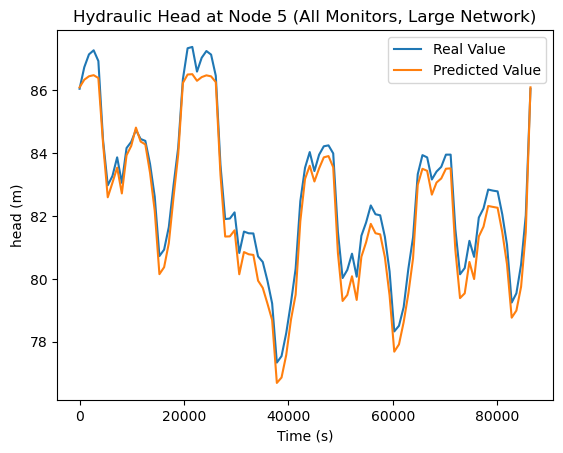

In [68]:
head_at_node5 = head.loc[:,'node_0005']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (All Monitors, Large Network)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (All Monitors, Large Network).png')
plt.show()

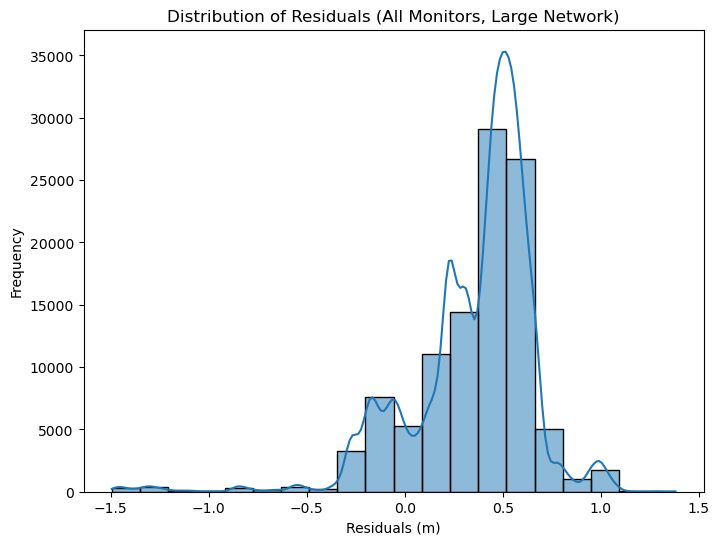

In [69]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (All Monitors, Large Network)')
plt.savefig('Distribution of Residuals (All Monitors, Large Network).png')
plt.show()

In [64]:
residuals.max()

1.38140869140625

In [65]:
residuals.min()

-1.4947662353515625

C:\Users\TianZhang\AppData\Local\Temp\ipykernel_23204\382666381.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Distribution of Heads (All Monitors, Large Network).png')
C:\Users\TianZhang\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


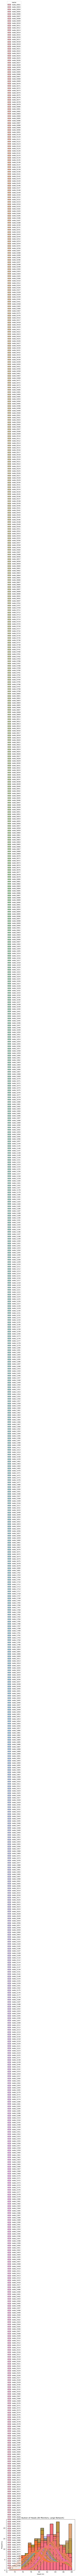

In [7]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(head, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Head (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Heads')
plt.title('Distribution of Heads (All Monitors, Large Network)')
plt.savefig('Distribution of Heads (All Monitors, Large Network).png')
plt.show()